In [1]:
import pandas as pd

df = pd.read_csv('data/DATASET_ic50_cleaned_compounds.csv')

In [6]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_murcko_scaffold(smiles):
    """Extract Murcko scaffold from SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

# Apply scaffold generation
print("Generating Murcko scaffolds...")
df['scaffold'] = df['smiles'].apply(get_murcko_scaffold)

# Filter out compounds where scaffold generation failed
df_valid = df[df['scaffold'].notna()].copy()

print(f"Compounds with valid scaffolds: {len(df_valid):,} / {len(df):,}")
print(f"Failed scaffold generation: {len(df) - len(df_valid):,}")


Generating Murcko scaffolds...
Compounds with valid scaffolds: 422 / 422
Failed scaffold generation: 0


In [7]:
from collections import Counter

# Count compounds per scaffold
scaffold_counts = Counter(df_valid['scaffold'])

print(f"Total unique scaffolds: {len(scaffold_counts):,}")
print(f"\nScaffold distribution:")
print(f"  Singletons (1 compound): {sum(1 for c in scaffold_counts.values() if c == 1):,}")
print(f"  Small series (2-5): {sum(1 for c in scaffold_counts.values() if 2 <= c <= 5):,}")
print(f"  Medium series (6-20): {sum(1 for c in scaffold_counts.values() if 6 <= c <= 20):,}")
print(f"  Large series (>20): {sum(1 for c in scaffold_counts.values() if c > 20):,}")

# Show top 10 most common scaffolds
print(f"\nTop 10 scaffolds by compound count:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"  {count:4d} compounds: {scaffold[:50]}..." if len(scaffold) > 50 else f"  {count:4d} compounds: {scaffold}")


Total unique scaffolds: 168

Scaffold distribution:
  Singletons (1 compound): 121
  Small series (2-5): 36
  Medium series (6-20): 7
  Large series (>20): 4

Top 10 scaffolds by compound count:
    50 compounds: c1ccc(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(C4)N5)c3...
    49 compounds: c1ccc2c(-c3cc4nc(OCC56CCCN5CCC6)nc(N5CC6CCC(C5)N6)...
    31 compounds: c1ccc2c(-c3cc4ncnc(N5CC6CCC(C5)N6)c4cn3)cccc2c1
    27 compounds: c1ccc2c(-c3cc4nc(OC[C@@H]5CCCN5)nc(N5CC6CCC(C5)N6)...
     9 compounds: c1ccc(C2CC2)c(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(...
     8 compounds: O=C1CNC(=O)C(Cc2ccccc2)NC(=O)CNC(=O)C2CCCN2C(=O)CC...
     8 compounds: c1ccc2c(-c3cc4nc(N5CCC5)nc(N5CC6CCC(C5)N6)c4cn3)cc...
     6 compounds: O=C1CNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)CNC(=O)C2C...
     6 compounds: c1cncc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc4...
     6 compounds: c1ccc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc45...


In [8]:
import numpy as np

def scaffold_split(df, smiles_col='smiles', test_size=0.1, val_size=0.1, random_state=42):
    """
    Perform scaffold-based train/validation/test split.
    
    All molecules sharing a scaffold are assigned to the same partition.
    Scaffolds are sorted by size (largest first) for balanced splits.
    
    Returns: train_idx, val_idx, test_idx (lists of DataFrame indices)
    """
    np.random.seed(random_state)
    
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    
    # Group indices by scaffold
    scaffold_to_indices = {}
    for idx, scaffold in zip(df.index, scaffolds):
        if scaffold is None:
            scaffold = f'NONE_{idx}'  # Treat parsing failures as singletons
        if scaffold not in scaffold_to_indices:
            scaffold_to_indices[scaffold] = []
        scaffold_to_indices[scaffold].append(idx)
    
    # Sort scaffolds by size (largest first) for better balance
    scaffold_sets = list(scaffold_to_indices.values())
    scaffold_sets.sort(key=len, reverse=True)
    
    # Calculate target sizes
    n_total = len(df)
    n_test = int(n_total * test_size)
    n_val = int(n_total * val_size)
    
    # Assign scaffolds to splits
    train_idx, val_idx, test_idx = [], [], []
    
    for indices in scaffold_sets:
        # Assign to smallest partition that hasn't reached target
        if len(test_idx) < n_test:
            test_idx.extend(indices)
        elif len(val_idx) < n_val:
            val_idx.extend(indices)
        else:
            train_idx.extend(indices)
    
    return train_idx, val_idx, test_idx


In [9]:
# Perform scaffold-based split
train_idx, val_idx, test_idx = scaffold_split(
    df_valid,
    smiles_col='smiles',
    test_size=0.1,
    val_size=0.1,
    random_state=42
)

# Create split DataFrames
df_train = df_valid.loc[train_idx].copy()
df_val = df_valid.loc[val_idx].copy()
df_test = df_valid.loc[test_idx].copy()

print(f"Scaffold-based split:")
print(f"  Train: {len(df_train):,} compounds ({100*len(df_train)/len(df_valid):.1f}%)")
print(f"  Val:   {len(df_val):,} compounds ({100*len(df_val)/len(df_valid):.1f}%)")
print(f"  Test:  {len(df_test):,} compounds ({100*len(df_test)/len(df_valid):.1f}%)")


Scaffold-based split:
  Train: 323 compounds (76.5%)
  Val:   49 compounds (11.6%)
  Test:  50 compounds (11.8%)


In [10]:
# Verify zero scaffold overlap
train_scaffolds = set(df_train['scaffold'])
val_scaffolds = set(df_val['scaffold'])
test_scaffolds = set(df_test['scaffold'])

train_val_overlap = train_scaffolds.intersection(val_scaffolds)
train_test_overlap = train_scaffolds.intersection(test_scaffolds)
val_test_overlap = val_scaffolds.intersection(test_scaffolds)

print("Scaffold Overlap Verification:")
print(f"  Train-Val overlap: {len(train_val_overlap)} scaffolds")
print(f"  Train-Test overlap: {len(train_test_overlap)} scaffolds")
print(f"  Val-Test overlap: {len(val_test_overlap)} scaffolds")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("\n[SUCCESS] Zero scaffold overlap - split integrity verified!")
else:
    print("\n[ERROR] Scaffold overlap detected - check implementation!")


Scaffold Overlap Verification:
  Train-Val overlap: 0 scaffolds
  Train-Test overlap: 0 scaffolds
  Val-Test overlap: 0 scaffolds

[SUCCESS] Zero scaffold overlap - split integrity verified!


In [11]:
# Analyze pIC50 distributions across splits
print("pIC50 Distribution Analysis:")
print(f"{'Partition':<10} {'Count':>8} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 58)

for name, data in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    print(f"{name:<10} {len(data):>8,} {data['pIC50'].mean():>8.2f} {data['pIC50'].std():>8.2f} {data['pIC50'].min():>8.2f} {data['pIC50'].max():>8.2f}")

print("-" * 58)
print(f"{'Total':<10} {len(df_valid):>8,} {df_valid['pIC50'].mean():>8.2f} {df_valid['pIC50'].std():>8.2f} {df_valid['pIC50'].min():>8.2f} {df_valid['pIC50'].max():>8.2f}")


pIC50 Distribution Analysis:
Partition     Count     Mean      Std      Min      Max
----------------------------------------------------------
Train           323     6.42     1.12     4.41     9.15
Val              49     7.77     1.17     5.51     9.70
Test             50     6.33     0.75     5.10     8.80
----------------------------------------------------------
Total           422     6.57     1.17     4.41     9.70


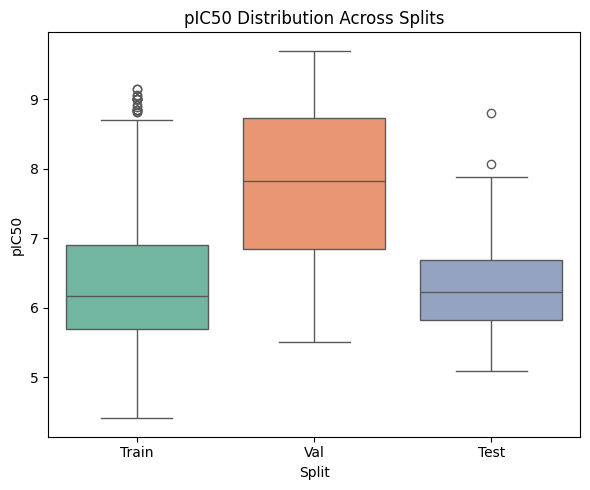

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data with labels
df_train['Split'] = 'Train'
df_val['Split'] = 'Val'
df_test['Split'] = 'Test'
df_combined = pd.concat([df_train, df_val, df_test])

# Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_combined, x='Split', y='pIC50', hue='Split',
            order=['Train', 'Val', 'Test'], palette='Set2', legend=False)
plt.title('pIC50 Distribution Across Splits')
plt.tight_layout()
plt.show()


In [14]:
# Create index mapping from SMILES to row position

df_ecfp4_final = pd.read_csv("data/DATASET_ecfp4.csv")
df_maccs_final = pd.read_csv("data/DATASET_maccs.csv")
df_rdkit_final = pd.read_csv("data/DATASET_rdkit.csv")
df_fingerprints_combined = pd.read_csv("data/DATASET_fp_combined.csv")

smiles_to_split = {}
for idx in train_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'train'
for idx in val_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'val'
for idx in test_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'test'
 
def split_by_smiles(df, smiles_col='smiles'):
    """Split DataFrame using SMILES-based assignment."""
    df['split'] = df[smiles_col].map(smiles_to_split)
    train = df[df['split'] == 'train'].drop(columns=['split'])
    val = df[df['split'] == 'val'].drop(columns=['split'])
    test = df[df['split'] == 'test'].drop(columns=['split'])
    return train, val, test
 
# Split all fingerprint datasets
fp_ecfp4_train, fp_ecfp4_val, fp_ecfp4_test = split_by_smiles(df_ecfp4_final)
fp_maccs_train, fp_maccs_val, fp_maccs_test = split_by_smiles(df_maccs_final)
fp_rdkit_train, fp_rdkit_val, fp_rdkit_test = split_by_smiles(df_rdkit_final)
fp_combined_train, fp_combined_val, fp_combined_test = split_by_smiles(df_fingerprints_combined)
 
print(f"ECFP4 split: train={len(fp_ecfp4_train)}, val={len(fp_ecfp4_val)}, test={len(fp_ecfp4_test)}")
print(f"MACCS split: train={len(fp_maccs_train)}, val={len(fp_maccs_val)}, test={len(fp_maccs_test)}")
print(f"RDKIT split: train={len(fp_rdkit_train)}, val={len(fp_rdkit_val)}, test={len(fp_rdkit_test)}")
print(f"Combined FP split: train={len(fp_combined_train)}, val={len(fp_combined_val)}, test={len(fp_combined_test)}")

ECFP4 split: train=323, val=49, test=50
MACCS split: train=323, val=49, test=50
RDKIT split: train=323, val=49, test=50
Combined FP split: train=323, val=49, test=50


In [15]:
# Split descriptor dataset
df_descriptors = pd.read_csv("data/DATASET_descriptors.csv")
desc_train, desc_val, desc_test = split_by_smiles(df_descriptors)
print(f"Descriptor split: train={len(desc_train)}, val={len(desc_val)}, test={len(desc_test)}")

Descriptor split: train=323, val=49, test=50


In [16]:
import os
import shutil

# Create splits directory
os.makedirs('splits', exist_ok=True)

# Save ECFP4 splits
fp_ecfp4_train.to_csv('splits/DATASET_ecfp4_train.csv', index=False)
fp_ecfp4_val.to_csv('splits/DATASET_ecfp4_val.csv', index=False)
fp_ecfp4_test.to_csv('splits/DATASET_ecfp4_test.csv', index=False)

# Save MACCS splits
fp_maccs_train.to_csv('splits/DATASET_maccs_train.csv', index=False)
fp_maccs_val.to_csv('splits/DATASET_maccs_val.csv', index=False)
fp_maccs_test.to_csv('splits/DATASET_maccs_test.csv', index=False)

# Save RDKit fingerprint splits
fp_rdkit_train.to_csv('splits/DATASET_rdkit_fp_train.csv', index=False)
fp_rdkit_val.to_csv('splits/DATASET_rdkit_fp_val.csv', index=False)
fp_rdkit_test.to_csv('splits/DATASET_rdkit_fp_test.csv', index=False)

# Save combined fingerprint splits
fp_combined_train.to_csv('splits/DATASET_fingerprints_combined_train.csv', index=False)
fp_combined_val.to_csv('splits/DATASET_fingerprints_combined_val.csv', index=False)
fp_combined_test.to_csv('splits/DATASET_fingerprints_combined_test.csv', index=False)

# Save descriptor splits
desc_train.to_csv('splits/DATASET_descriptors_train.csv', index=False)
desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test.to_csv('splits/DATASET_descriptors_test.csv', index=False)

print("All split datasets saved to 'splits/' directory")
print(f"Files created: {len(os.listdir('splits'))}")


All split datasets saved to 'splits/' directory
Files created: 15



ECFP4:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 323, Val: 49, Test: 50

MACCS:
  Feature columns: 167
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 323, Val: 49, Test: 50

RDKit Fingerprints:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 323, Val: 49, Test: 50

Combined Fingerprints:
  Feature columns: 4263
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 323, Val: 49, Test: 50

Descriptors:
  Feature columns: 89
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 323, Val: 49, Test: 50


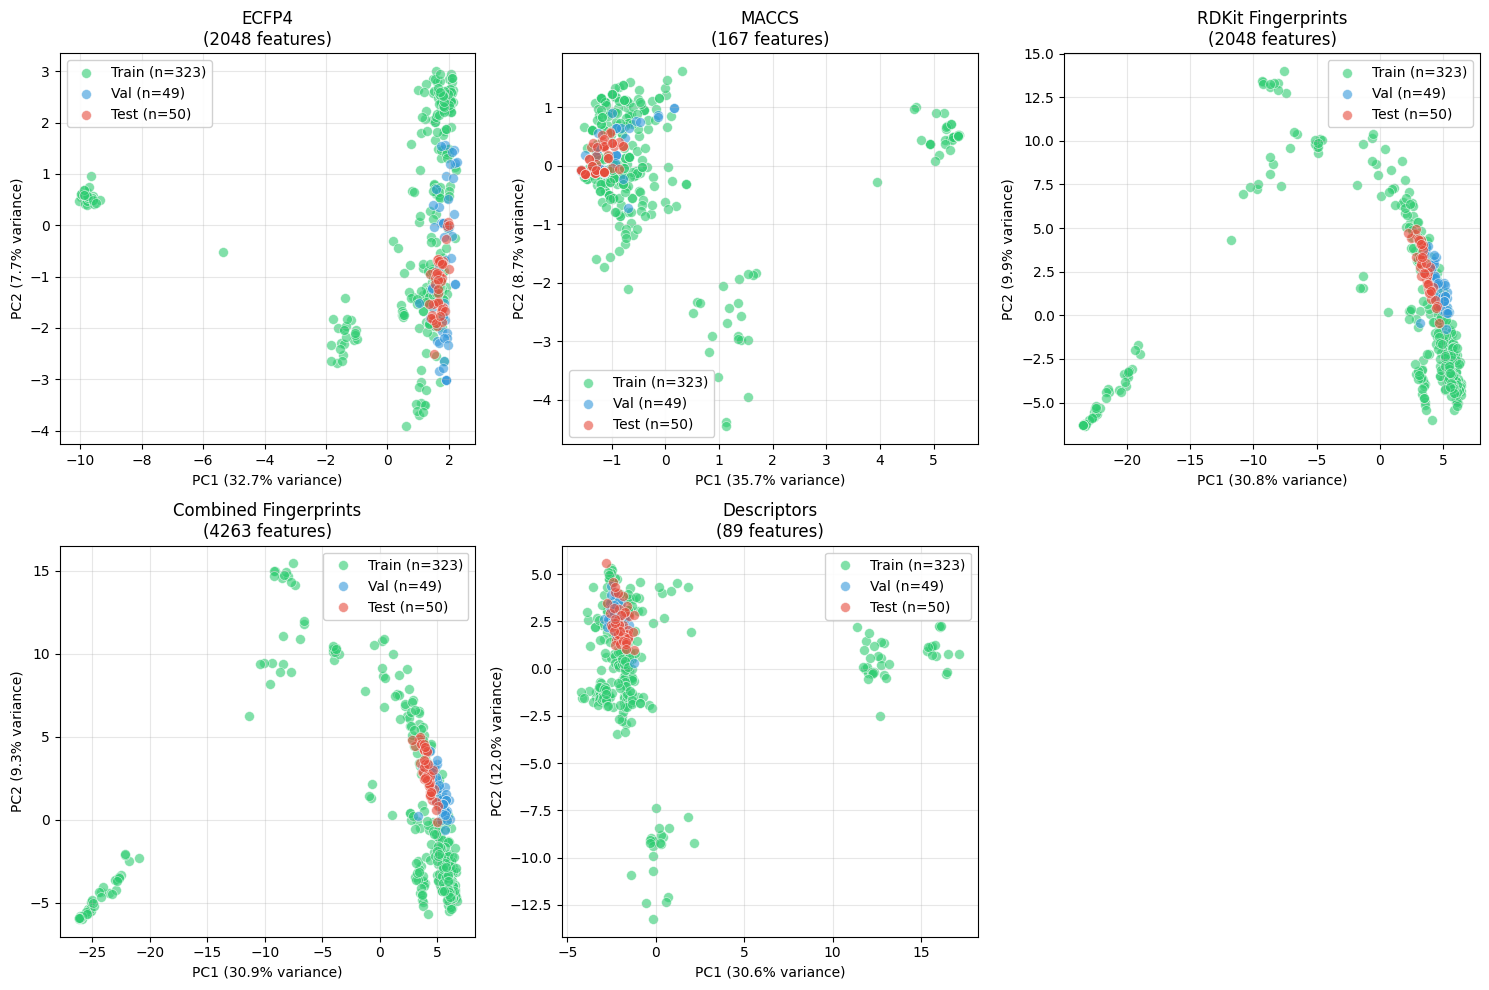

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the 5 methods and their file prefixes
methods = {
    'ECFP4': 'DATASET_ecfp4',
    'MACCS': 'DATASET_maccs',
    'RDKit Fingerprints': 'DATASET_rdkit_fp',
    'Combined Fingerprints': 'DATASET_fingerprints_combined',
    'Descriptors': 'DATASET_descriptors'
}

# Columns to exclude (non-feature columns)
EXCLUDE_COLS = ['molecule_chembl_id', 'smiles', 'pIC50']

def detect_feature_columns(df):
    """
    Detect feature columns by excluding specified non-feature columns.
    """
    non_feature_cols = [col for col in df.columns if col in EXCLUDE_COLS]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols, non_feature_cols

def load_splits(file_prefix, splits_dir='splits'):
    """
    Load train, validation, and test splits for a given method.
    """
    train_df = pd.read_csv(f'{splits_dir}/{file_prefix}_train.csv')
    val_df = pd.read_csv(f'{splits_dir}/{file_prefix}_val.csv')
    test_df = pd.read_csv(f'{splits_dir}/{file_prefix}_test.csv')
    return train_df, val_df, test_df

def plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=None):
    """
    Perform PCA and plot for train/val/test subsets of a given method.
    """
    # Load data
    train_df, val_df, test_df = load_splits(file_prefix, splits_dir)

    # Detect feature columns
    feature_cols, non_feature_cols = detect_feature_columns(train_df)

    print(f"\n{method_name}:")
    print(f"  Feature columns: {len(feature_cols)}")
    print(f"  Excluded columns: {non_feature_cols}")
    print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    # Extract features
    X_train = train_df[feature_cols].values.astype(float)
    X_val = val_df[feature_cols].values.astype(float)
    X_test = test_df[feature_cols].values.astype(float)

    # Only scale for Descriptors
    if method_name == 'Descriptors':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    # Perform PCA (fit on train, transform all)
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train)
    val_pca = pca.transform(X_val)
    test_pca = pca.transform(X_test)

    # Get explained variance
    var_explained = pca.explained_variance_ratio_ * 100

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label=f'Train (n={len(train_df)})',
               c='#2ecc71', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(val_pca[:, 0], val_pca[:, 1], alpha=0.6, label=f'Val (n={len(val_df)})',
               c='#3498db', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label=f'Test (n={len(test_df)})',
               c='#e74c3c', edgecolors='white', linewidth=0.5, s=50)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% variance)')
    ax.set_title(f'{method_name}\n({len(feature_cols)} features)')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)

    return pca, var_explained

# Main execution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method_name, file_prefix) in enumerate(methods.items()):
    plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=axes[idx])

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()
